In [1]:
import numpy as np
import os
import csv
from scipy.stats import poisson
from scipy.stats import norm
import pandas as pd
import itertools
import matplotlib.pyplot as plot
%run -i utils.py

### Historical training

In [2]:
fixture_list_1, fixture_list_2, fixture_list_3 = import_fixture_lists("../data/prem_results_20162017.csv",
                                                                      "../data/prem_results_20172018.csv",
                                                                      "../data/prem_results_20182019.csv")

In [3]:
# all teams in three seasons and fourth season
team_list = np.concatenate((np.unique(fixture_list_1.as_matrix()[:, 0]),
                            np.unique(fixture_list_2.as_matrix()[:, 0]),
                            np.unique(fixture_list_3.as_matrix()[:, 0]),
                            ((pd.read_csv("../data/team_id_20192020.csv", header=0)).as_matrix())[:, 0]))

utils.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import os
utils.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import csv
utils.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from scipy.stats import poisson
utils.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from scipy.stats import norm


In [4]:
teams = np.unique(team_list)

In [5]:
fl1 = fixture_list_1.as_matrix()
fl2 = fixture_list_2.as_matrix()
fl3 = fixture_list_3.as_matrix()

utils.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import numpy as np
utils.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import os
utils.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import csv


In [6]:
# test
a = np.ones(len(teams)) * 0.1
d = np.ones(len(teams)) * 0.1
mu = 0.1
intercept = 0.1
l = likelihood_season(fl1, teams, intercept, mu, a, d)

In [7]:
# test
predict_fixtures(fl1[1:3, :], teams, intercept, mu, a, d)

(array([1.4918247, 1.4918247]), array([1.34985881, 1.34985881]))

In [20]:
priormeans = np.ones((2 * len(teams)) + 2) * 0.0
priorsds = np.ones((2 * len(teams)) + 2) * 0.15
beta = 0.0002
niter = 30000

# prior-out promoted teams
inds = list(np.where(teams == 'Norwich')[0])
inds.append(np.where(teams == 'Aston Villa')[0][0])
inds.append(np.where(teams == 'Sheffield United')[0][0])
inds = np.array(inds)

est = EstimateParameters(fl1, fl2, fl3, teams, beta, priormeans, priorsds, niter=niter, zerooutinds=inds)

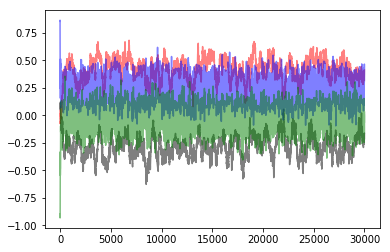

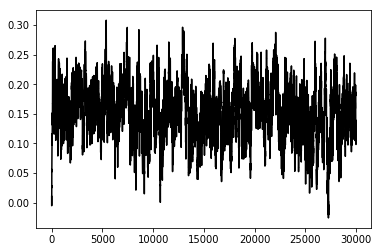

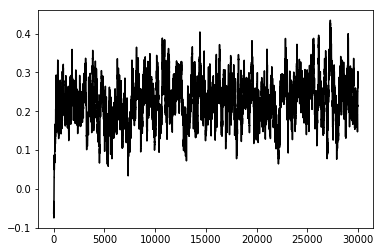

In [13]:
tm = 'Man City'
plot.plot(est[:, (2 + np.where(teams == tm)[0][0]).astype(int)], 'r', alpha=0.5)
plot.plot(est[:, (len(teams) + 2 + np.where(teams == tm)[0][0]).astype(int)], 'k', alpha=0.5)

tm = 'Arsenal'
plot.plot(est[:, (2 + np.where(teams == tm)[0][0]).astype(int)], 'b', alpha=0.5)
plot.plot(est[:, (len(teams) + 2 + np.where(teams == tm)[0][0]).astype(int)], 'g', alpha=0.5)
plot.show()

plot.plot(est[:, 0], 'k')
plot.show()

plot.plot(est[:, 1], 'k')
plot.show()

#### Save parameters

In [21]:
# save parameters
burn = int((1 * niter) / 5)
int_mean = np.array([np.mean(est[burn:, 0])])
int_sd = np.array([np.std(est[burn:, 0])])
mu_mean = np.array([np.mean(est[burn:, 1])])
mu_sd = np.array([np.std(est[burn:, 1])])
a_mean = np.mean(est[burn:, 2:(len(teams) + 2)], axis=0)
a_sd = np.std(est[burn:, 2:(len(teams) + 2)], axis=0)
d_mean = np.mean(est[burn:, (len(teams) + 2):((2 * len(teams)) + 2)], axis=0)
d_sd = np.std(est[burn:, (len(teams) + 2):((2 * len(teams)) + 2)], axis=0)
means = np.concatenate((int_mean, mu_mean, a_mean, d_mean))
sds = np.concatenate((int_sd, mu_sd, a_sd, d_sd))

sds[2 + inds] = 0.15
sds[2 + len(teams) + inds] = 0.15

with open('../parameters/all_teams.csv', mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for tm in teams:
        csv_writer.writerow([tm])
csv_file.close()

with open('../parameters/all_teams_params.csv', mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i in range(((2 * len(teams)) + 2)):
        csv_writer.writerow([means[i], sds[i]])
csv_file.close()

[18  1 19]


In [17]:
sds[2:(len(teams)+2)]

array([0.09654224, 0.15      , 0.09089884, 0.11293029, 0.11041114,
       0.12420139, 0.09065041, 0.10942255, 0.10424359, 0.1296018 ,
       0.09722535, 0.13120417, 0.10129506, 0.09450708, 0.0955551 ,
       0.09183761, 0.12878411, 0.123929  , 0.15814863, 0.15      ,
       0.09898296, 0.10998366, 0.14003356, 0.1272919 , 0.08668595,
       0.10933727, 0.13501188, 0.10496069, 0.12435299])

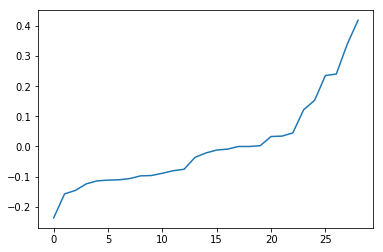

In [18]:
plot.plot(np.sort(means[2:(len(teams)+2)]))